**Env setup**
- Ensure you connect GPU - T4 or A100
- DETR compatability: PyTorch >= 2.0.0 & Torchvision 0.15.0 || Official detr repo link [here](https://github.com/facebookresearch/detr#requirements)
- Load DETR from torch.hub, because torchvision.models.detection errors see below.
- nuScenes mini split reference link [here](https://colab.research.google.com/github/nutonomy/nuscenes-devkit/blob/master/python-sdk/tutorials/nuscenes_tutorial.ipynb#scrollTo=WRSobaxUH1zr)

In [ ]:
#verify current PyTorch and Torchvision versions - compatibality.
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

from torchvision.transforms import functional as F
from nuscenes.nuscenes import NuScenes
import matplotlib.pyplot as plt
from PIL import Image


#Uncomment if needed:
#!pip install torch==2.0.0 torchvision==0.15.0 -f https://download.pytorch.org/whl/cu118/torch_stable.html
#!pip install opencv-python matplotlib
#!pip install nuscenes-devkit &> /dev/null
#!pip install opencv-python matplotlib

PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121


In [ ]:
#uncompress and directly mount drive for mini split from nuScenes
!mkdir -p /data/sets/nuscenes
!wget https://www.nuscenes.org/data/v1.0-mini.tgz
!tar -xf v1.0-mini.tgz -C /data/sets/nuscenes

--2024-10-16 02:19:42--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 108.157.254.107, 108.157.254.96, 108.157.254.18, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|108.157.254.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz’

v1.0-mini.tgz       100%[===================>]   3.88G   223MB/s    in 20s     

2024-10-16 02:20:02 (202 MB/s) - ‘v1.0-mini.tgz’ saved [4167696325/4167696325]



In [ ]:
%matplotlib inline
nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.952 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [ ]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [ ]:
scene = nusc.scene[0]
sample = nusc.get('sample', scene['first_sample_token'])

In [ ]:
# Get the front camera image
cam_front_data = nusc.get('sample_data', sample['data']['CAM_FRONT'])
image_path = nusc.get_sample_data_path(cam_front_data['token'])

# Load the image
image = Image.open(image_path)

In [ ]:
#torch hub direct load DETR model from facebook's repository
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval() # Eval mode just for inference

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 97.0MB/s]
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cach

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [ ]:
#preprocess image - normalize as per torchhub reqs
image_tensor = F.to_tensor(image).unsqueeze(0)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
image_tensor = image_tensor.to(device)

In [ ]:
#Inferencing
with torch.no_grad():
    outputs = model(image_tensor)

#class probabilities and threshold to filter
probabilities = outputs['pred_logits'].softmax(-1)[0, :, :-1]
threshold = 0.9
keep = probabilities.max(-1).values > threshold

#bounding boxes output, retain on cpu
boxes = outputs['pred_boxes'][0, keep].cpu()

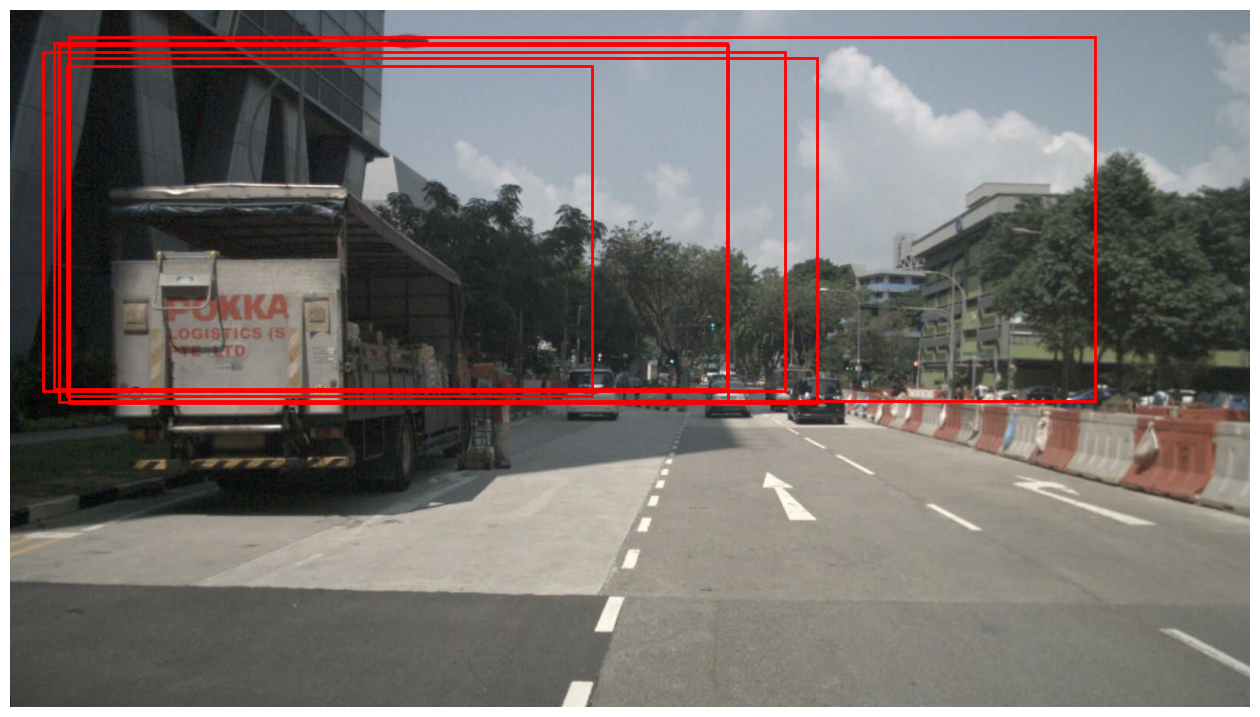

In [ ]:
#rescaling from torch tensors for ploting results
def rescale_bboxes(boxes, size):
    img_w, img_h = size
    boxes = boxes * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return boxes
boxes_rescaled = rescale_bboxes(boxes, image.size)

def plot_results(image, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()
    for (xmin, ymin, xmax, ymax) in boxes:
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='red', linewidth=2))
    plt.axis('off')
    plt.show()

plot_results(image, boxes_rescaled.numpy())


---

**Torch lib Debug Needed**
(no matter what version i try of torchvision, it's seems to be incompatible with detr_resnet50)

In [ ]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)


PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121


In [ ]:
!pip install torch==2.0.0 torchvision==0.15.0 -f https://download.pytorch.org/whl/cu118/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu118/torch_stable.html


In [ ]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)


PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.0+cu118


In [ ]:
!rm -rf ~/.cache/torch/hub/checkpoints

In [ ]:
!pip install --upgrade torchvision

In [ ]:
!pip install torch==2.0.1+cu121 torchvision==0.15.0+cu121 torchaudio==2.0.1+cu121 --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
ERROR: Could not find a version that satisfies the requirement torch==2.0.1+cu121 (from versions: 2.1.0+cu121, 2.1.1+cu121, 2.1.2+cu121, 2.2.0+cu121, 2.2.1+cu121, 2.2.2+cu121, 2.3.0+cu121, 2.3.1+cu121, 2.4.0+cu121, 2.4.1+cu121)
ERROR: No matching distribution found for torch==2.0.1+cu121


- Need for a specific version of PyTorch and Torchvision: [LINK](https://stackoverflow.com/questions/73029425/cannot-import-name-resnet50-weights-from-torchvision-models-resnet)

In [ ]:
#Installing PyTorch and Torchvision(hosts pre-trained DETR model) + utility functions
!pip install torch torchvision
!pip install opencv-python matplotlib

#Import
import torch
from torchvision.models.detection import detr_resnet50, DETR_ResNet50_Weights #Pretrained model hosted on Torchvision
from torchvision.transforms import functional as F #Helps with tranformations: resizing, normalizing and converting images
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests #if url image
from PIL import Image
from io import BytesIO

ImportError: cannot import name 'detr_resnet50' from 'torchvision.models.detection' (/usr/local/lib/python3.10/dist-packages/torchvision/models/detection/__init__.py)